<a href="https://colab.research.google.com/github/hirofsgit/Python_1/blob/main/Chap10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=99a41a4501e860170c20218e1be94fe9026c6d470e8a601e6ba5a64b10eebd68
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
import scipy
from scipy import stats, linalg
import copy
import pandas as pd
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess

# 10.1

In [ ]:
kidney = pd.read_csv("/content/kidney.txt", delimiter=" ")

In [ ]:
kidney.head()

,age,tot
0,18,2.44
1,19,3.86
2,19,-1.22
3,20,2.30
4,21,0.98


**Lowess model**

In [ ]:
low_preds = lowess(kidney.tot, kidney.age, frac=1/3.0)

In [ ]:
low_preds[:5]

array([[18.        ,  2.24792193],
       [19.        ,  1.95243881],
       [19.        ,  1.95243881],
       [20.        ,  1.65762652],
       [21.        ,  1.36364605]])

In [ ]:
ages = np.array(list(range(20, 90, 5)))

In [ ]:
n_ages = ages.shape[0]
n_obs = kidney.shape[0]

**Jackknife estimates**

In [ ]:
low_jacks = []
for i in range(n_obs):
    jack_tot = np.concatenate((kidney.tot[:i], kidney.tot[i + 1:]))
    jack_age = np.concatenate((kidney.age[:i], kidney.age[i + 1:]))
    new_preds = lowess(jack_tot, jack_age, frac=1/3.0)
    low_jacks.append(new_preds)

In [ ]:
# interpolate lowess predictions for age = 20, 30, ..., 80
jack_decs = np.zeros((n_ages, n_obs))
for i, pred in enumerate(low_jacks):
    # interp1d seems to have trouble with non-unique values
    pred = np.unique(pred, axis=0)
    # create an interpolator and collect each lowess's predictions
    interpolate = interp1d(pred[:, 0], pred[:, 1], fill_value="extrapolate", assume_sorted=True)
    jack_decs[:, i] = interpolate(ages)

# get estimate of theta
theta = jack_decs.mean(axis=1)

# get standard deviation for each age
jack_var = ((jack_decs - theta[:, None])**2).sum(axis=1) * (n_obs - 1) / n_obs
jack_sds = np.sqrt(jack_var)

**Boostrap estimates**

In [ ]:
n_boots = 500

In [ ]:
low_boots = []
for i in range(n_boots):
    boot_data = kidney.sample(n=kidney.shape[0], replace=True)
    new_preds = lowess(boot_data.tot, boot_data.age, frac=1/3.0)
    low_boots.append(new_preds)

In [ ]:
# interpolate lowess predictions for age = 20, 30, ..., 80
boot_decs = np.zeros((n_ages, n_boots))
for i, pred in enumerate(low_boots):
    # interp1d seems to have trouble with non-unique values
    pred = np.unique(pred, axis=0)
    # create an interpolator and collect each lowess's predictions
    interpolate = interp1d(pred[:, 0], pred[:, 1], fill_value="extrapolate", assume_sorted=True)
    boot_decs[:, i] = interpolate(ages)

# get standard deviation for each age
boot_var = np.var(boot_decs, axis=1, ddof=1)
boot_sds = np.sqrt(boot_var)

## 図10.1

In [ ]:
# interpolate the original lowess points for age = 20, 30, ..., 80
interpolate = interp1d(
    low_preds[:, 0],
    low_preds[:, 1],
    fill_value="extrapolate",
    assume_sorted=True
)

jack_se_lines = LineCollection(
    [
        [[age + 0.3, interpolate(age) - 2 * se], [age + 0.3, interpolate(age) + 2 * se]]
        for age, se in zip(ages, jack_sds)
    ],
    color="b",
    linestyle="--",
)

boot_se_lines = LineCollection(
    [
        [[age - 0.3, interpolate(age) - 2 * se], [age - 0.3, interpolate(age) + 2 * se]]
        for age, se in zip(ages, boot_sds)
    ],
    color="r",
)


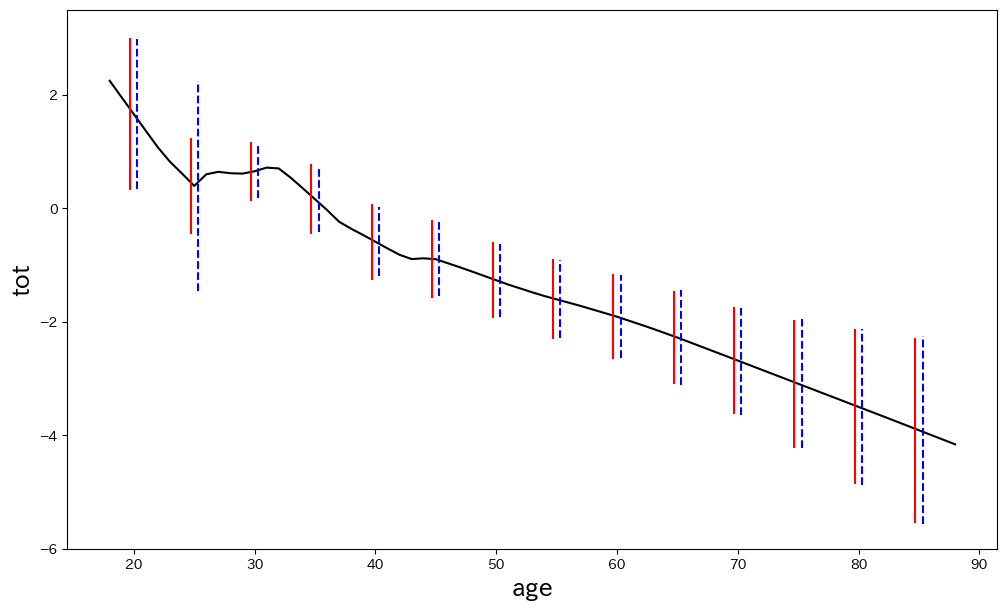

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

#ax.scatter(kidney.age, kidney.tot)
ax.plot(low_preds[:, 0], low_preds[:, 1], color="k")
ax.add_collection(jack_se_lines)
ax.add_collection(boot_se_lines)

ax.set_xlabel("age", size=18)
ax.set_ylabel("tot", size=18)

ax.set_ylim(-6, 3.5);

#10.3

In [ ]:
leukemia = pd.read_csv("/content/leukemia_big.csv")

In [ ]:
leukemia.head()

,ALL,ALL.1,ALL.2,ALL.3,ALL.4,ALL.5,ALL.6,ALL.7,ALL.8,ALL.9,...,AML.15,AML.16,AML.17,AML.18,AML.19,AML.20,AML.21,AML.22,AML.23,AML.24
0,-1.533622,-0.867610,-0.433172,-1.671903,-1.187689,-1.127234,-1.045409,-0.106917,-1.198796,-1.190899,...,-0.436650,-1.274708,-0.681458,-0.876610,-0.624022,-0.431628,-1.435259,-0.671954,-1.013161,-0.969482
1,-1.235673,-1.275501,-1.184492,-1.596424,-1.335256,-1.113730,-0.800880,-0.745177,-0.849312,-1.190899,...,-0.915483,-1.354363,-0.653559,-1.096250,-1.066594,-1.335256,-1.204586,-0.751457,-0.889592,-1.080988
2,-0.333983,0.375927,-0.459196,-1.422571,-0.797493,-1.362768,-0.671954,-1.175674,0.320813,0.646610,...,-0.736156,-0.022153,-0.037455,-0.567335,-1.100749,-0.552938,-0.948874,-0.231657,-0.742163,-0.779500
3,0.488702,0.444011,0.436264,0.193353,0.235632,-0.360312,0.184941,0.425653,0.333983,0.235270,...,0.083781,0.356562,0.416241,0.533986,0.227505,0.416816,0.408202,0.326556,0.361813,0.298864
4,-1.300893,-1.229660,-1.325882,-1.818329,-1.311206,-1.513975,-1.651624,-1.339555,-0.593132,0.133302,...,-1.547444,-1.264475,-1.512318,-1.469583,-1.283472,-0.977672,-1.090178,-1.545120,-1.174272,-1.443183


In [ ]:
all_cols = [x for x in leukemia.columns if x.startswith("ALL")]
aml_cols = [x for x in leukemia.columns if x.startswith("AML")]

all_vals = leukemia[all_cols].iloc[135].values
aml_vals = leukemia[aml_cols].iloc[135].values

## 図10.4

In [ ]:
mediff_est = (np.median(aml_vals) - np.median(all_vals))
mediff_est.round(3)

NameError: ignored

In [ ]:
n_all = all_vals.shape[0]
n_aml = aml_vals.shape[0]

n_boots = 500
bootvals = []
for _ in range(n_boots):
    aml_boot = np.random.choice(aml_vals, size=n_aml, replace=True)
    all_boot = np.random.choice(all_vals, size=n_all, replace=True)
    bootvals.append(np.median(aml_boot) - np.median(all_boot))

In [ ]:
np.sqrt(np.var(bootvals, ddof=1)).round(3)

0.069

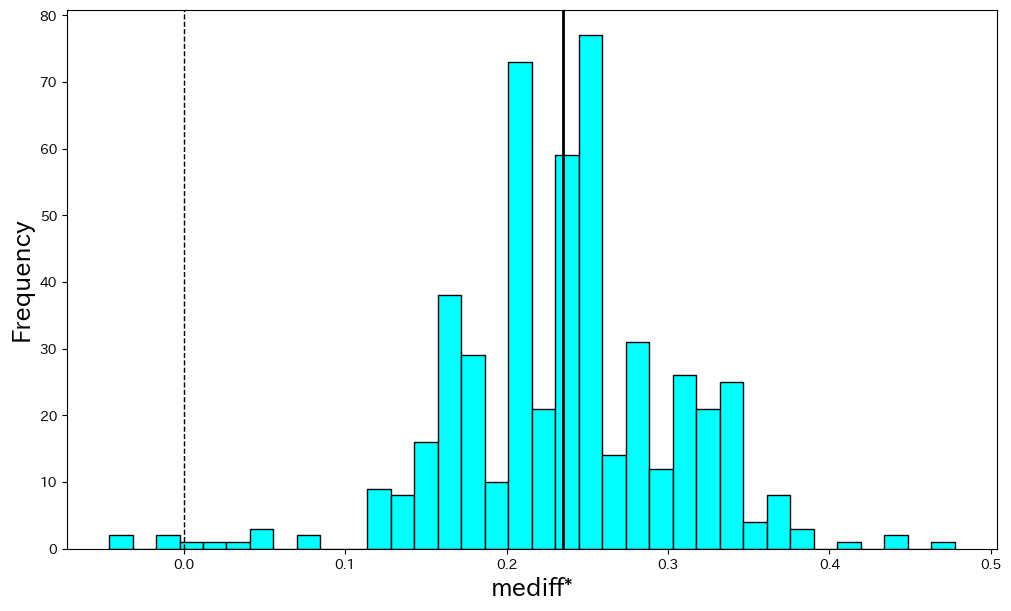

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.hist(bootvals, bins=36, color="cyan", edgecolor="k")
ax.axvline(mediff_est, c="k", linewidth=2)
ax.axvline(0, c="k", linestyle="--", linewidth=1)

ax.set_xlabel("mediff*", size=18)
ax.set_ylabel("Frequency", size=18);

B=200でやってみる

In [ ]:
n_all = all_vals.shape[0]
n_aml = aml_vals.shape[0]

n_boots = 200
bootvals = []
for _ in range(n_boots):
    aml_boot = np.random.choice(aml_vals, size=n_aml, replace=True)
    all_boot = np.random.choice(all_vals, size=n_all, replace=True)
    bootvals.append(np.median(aml_boot) - np.median(all_boot))

In [ ]:
np.sqrt(np.var(bootvals, ddof=1)).round(3)

0.063

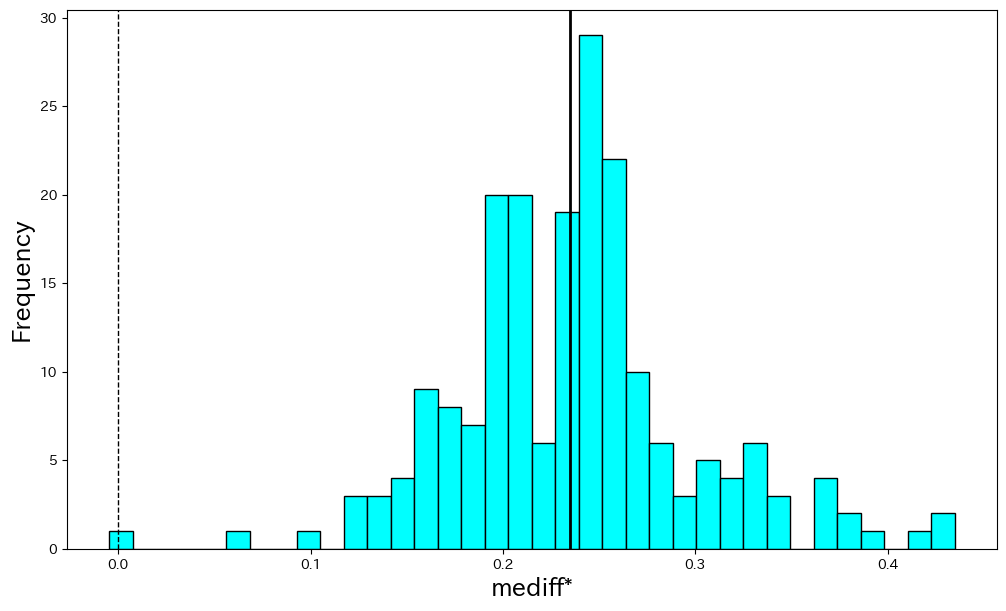

In [ ]:
ig, ax = plt.subplots(figsize=(12, 7))

ax.hist(bootvals, bins=36, color="cyan", edgecolor="k")
ax.axvline(mediff_est, c="k", linewidth=2)
ax.axvline(0, c="k", linestyle="--", linewidth=1)

ax.set_xlabel("mediff*", size=18)
ax.set_ylabel("Frequency", size=18);

# 10.4

### 図10.5

In [ ]:
gfr = pd.read_csv("/content/gfr.txt", delimiter=" ", header=None, names=["gfr"])
gfr = gfr.gfr.values

In [ ]:
frequency, edges = np.histogram(gfr, bins=np.arange(13, 112, 3))

In [ ]:
centers = (edges[:-1] + edges[1:]) / 2

In [ ]:
edges

array([ 13,  16,  19,  22,  25,  28,  31,  34,  37,  40,  43,  46,  49,
        52,  55,  58,  61,  64,  67,  70,  73,  76,  79,  82,  85,  88,
        91,  94,  97, 100, 103, 106, 109])

In [ ]:
centers

array([ 14.5,  17.5,  20.5,  23.5,  26.5,  29.5,  32.5,  35.5,  38.5,
        41.5,  44.5,  47.5,  50.5,  53.5,  56.5,  59.5,  62.5,  65.5,
        68.5,  71.5,  74.5,  77.5,  80.5,  83.5,  86.5,  89.5,  92.5,
        95.5,  98.5, 101.5, 104.5, 107.5])

In [ ]:
def make_poly(x, degree, orthogonal=False):
    x_mat = np.transpose(np.vstack((x**k for k in range(degree + 1))))
    if orthogonal:
        x_mat = np.linalg.qr(x_mat)[0]
        x_mat[:, 0] = 1
    columns = ["x{}".format(i) for i in range(degree + 1)]
    return pd.DataFrame(x_mat, columns=columns)

In [ ]:
def poisson_pts(y, x, degree, orthogonal=False, print_summary=False):
    # create polynomial dataset
    X = make_poly(x, degree, orthogonal)
    #pd.DataFrame({"x{}".format(i): x**i for i in range(degree + 1)})

    # fit model
    model = sm.GLM(y, X, family=sm.families.Poisson())
    results = model.fit()

    if print_summary:
        print(results.summary())

    # get y-values at input values
    y_center = results.predict(X)

    # make x,y points for the line
    if orthogonal:
        x_line = x
    else:
        x_line = np.arange(15, 109, 1)
    graph_X = make_poly(x_line, degree, orthogonal)
    # pd.DataFrame({"x{}".format(i): x_line**i for i in range(degree + 1)})
    y_line = results.predict(graph_X)

    return x_line, y_line, y_center

In [ ]:
x, y2, y2_center = poisson_pts(frequency, centers, degree=2)
_, y3, y3_center = poisson_pts(frequency, centers, degree=3)
_, y4, y4_center = poisson_pts(frequency, centers, degree=4)
_, y5, y5_center = poisson_pts(frequency, centers, degree=5)
_, y6, y6_center = poisson_pts(frequency, centers, degree=6)
_, y7, y7_center = poisson_pts(frequency, centers, degree=7)

In [ ]:
_

array([ 15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108])

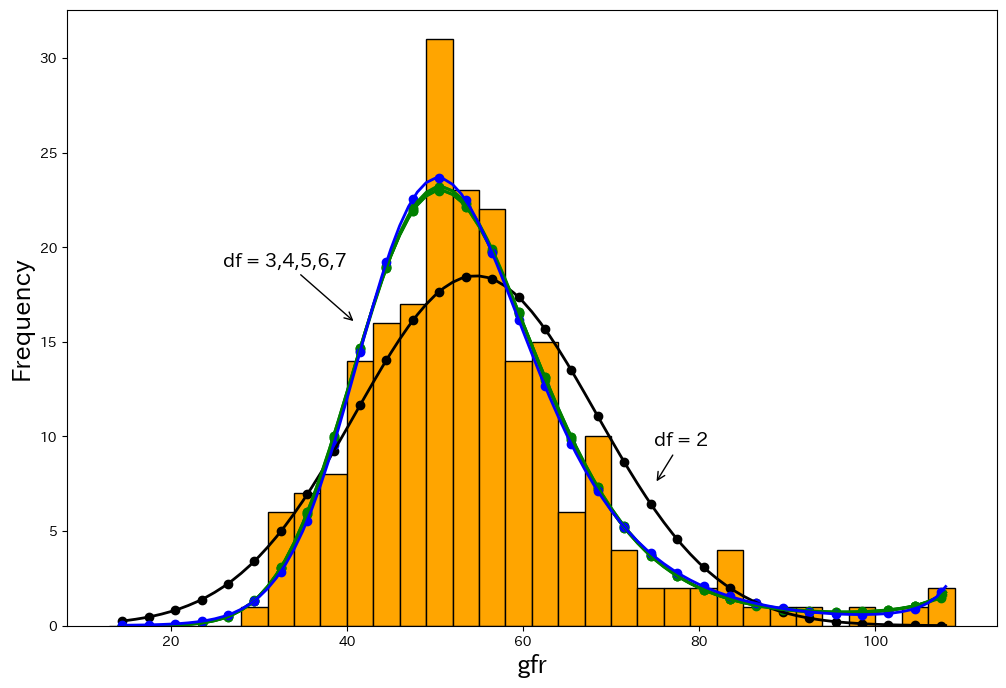

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(
    centers,
    frequency,
    width=np.diff(edges),
    align="center",
    edgecolor="k",
    color="orange",
    zorder=-1,
)

ax.plot(x, y2, c="k", linewidth=2)
ax.scatter(centers, y2_center, c="k")

ax.plot(x, y3, c="g", linewidth=2)
ax.scatter(centers, y3_center, c="g")

ax.plot(x, y4, c="g", linewidth=2)
ax.scatter(centers, y4_center, c="g")

ax.plot(x, y5, c="g", linewidth=2)
ax.scatter(centers, y5_center, c="g")

ax.plot(x, y6, c="g", linewidth=2)
ax.scatter(centers, y6_center, c="g")

ax.plot(x, y7, c="b", linewidth=2)
ax.scatter(centers, y7_center, c="b")

ax.annotate(
    "df = 2",
    size=14,
    xy=(75, 7.5),
    xytext=(78, 9.5),
    arrowprops=dict(
        arrowstyle="->",
        facecolor="black",
    ),
    horizontalalignment="center",
)

ax.annotate(
    "df = 3,4,5,6,7",
    size=14,
    xy=(41, 16),
    xytext=(33, 19),
    arrowprops=dict(
        arrowstyle="->",
        facecolor="black",
    ),
    horizontalalignment="center",
)

ax.set_xlabel("gfr", size=18)
ax.set_ylabel("Frequency", size=18);


(10.56)

In [ ]:
degree=2
X = make_poly(x, degree, False)
    #pd.DataFrame({"x{}".format(i): x**i for i in range(degree + 1)})

    # fit model
model = sm.GLM(y, X, family=sm.families.Poisson())
results = model.fit()
results

NameError: ignored